In [520]:
import os
from os import listdir
import pandas as pd
import numpy as np
import glob
import cv2
import json
from os.path import expanduser
import splitfolders
import shutil
from define_path import Def_Path

from tqdm import tqdm

import torch 
import torchvision
from torchvision import models
from torchvision.models.detection.rpn import AnchorGenerator
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torchsummary import summary

from sklearn.model_selection import train_test_split

import albumentations as A # Library for augmentations

import matplotlib.pyplot as plt 
from PIL import Image

import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate


t = torch.cuda.get_device_properties(0).total_memory
print(t)
torch.cuda.empty_cache()

r = torch.cuda.memory_reserved(0)
print(r)
a = torch.cuda.memory_allocated(0)
print(a)
# f = r-a  # free inside reserved

16908615680
0
0


In [521]:
# to generalize home directory. User can change their parent path without entering their home directory
path = Def_Path()

# parent_path =  path.home + "/Workspace/WPI/Summer2023/ws/duc_repo/src/panda_test/" + "data/sim_marker/"
parent_path = path.home + "/lama/results/09_04_2023/"

# root_dir = parent_path + path.year + "-" + path.month + "-" + path.day + "/"
root_dir = parent_path + "rcnn" + "/"

print(root_dir)

/home/jc-merlab/lama/results/09_04_2023/rcnn/


In [522]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.cuda.set_per_process_memory_fraction(0.9, 0)
print(device)

cuda


In [523]:
# this fucntion tranforms an input image for diverseifying data for training
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1), # Random change of brightness & contrast
        ], p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

In [524]:
# this function is to split the dataset into train, test and validation folder.
def train_test_split(src_dir):
    dst_dir_img = src_dir + "images"
    dst_dir_anno = src_dir + "annotations"
    
    if os.path.exists(dst_dir_img) and os.path.exists(dst_dir_anno):
        print("folders exist")
    else:
        os.mkdir(dst_dir_img)
        os.mkdir(dst_dir_anno)
        
    for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
        shutil.copy(jpgfile, dst_dir_img)

    for jsonfile in glob.iglob(os.path.join(src_dir, "*.json")):
        shutil.copy(jsonfile, dst_dir_anno)
        
    output = parent_path + "split_folder_output" + "-" + path.year + "-" + path.month + "-" + path.day 
    
    print(output)
    
    splitfolders.ratio(src_dir, # The location of dataset
                   output=output, # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .2, .1), # The ratio of split dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )
    
    shutil.rmtree(dst_dir_img)
    shutil.rmtree(dst_dir_anno)
    
    return output
    

In [525]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo 
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])
        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        
        
        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']
            
            # All objects are keypoints on the arm
            bboxes_labels_original = [] 
            bboxes_labels_original.append('base_kp')
            bboxes_labels_original.append('kp2')
            bboxes_labels_original.append('kp3')
            bboxes_labels_original.append('ee_kp')

        if self.transform:
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,1,2)).tolist()
            
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened):
                obj_keypoints = []
                for k_idx, kp in enumerate(obj):
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original  

            # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
#         labels = [1, 2, 3, 4, 5, 6]   
        labels = [1, 2, 3, 4]
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64) # all objects are joint positions
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)
        img = F.to_tensor(img)        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor(labels, dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)


        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)
    

In [526]:
KEYPOINTS_FOLDER_TRAIN = train_test_split(root_dir) +"/train" 
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)
# print(batch[2])

# print("Original targets:\n", batch[3], "\n\n")
# print("Transformed targets:\n", batch[1])

/home/jc-merlab/lama/results/09_04_2023/split_folder_output-2023-09-07


Copying files: 11022 files [00:02, 4426.00 files/s]


[[[711, 399]], [[647, 320]], [[621, 242]], [[599, 175]]]
0
[[711, 399]]
[711, 399]
1
[[647, 320]]
[647, 320]
2
[[621, 242]]
[621, 242]
3
[[599, 175]]
[599, 175]


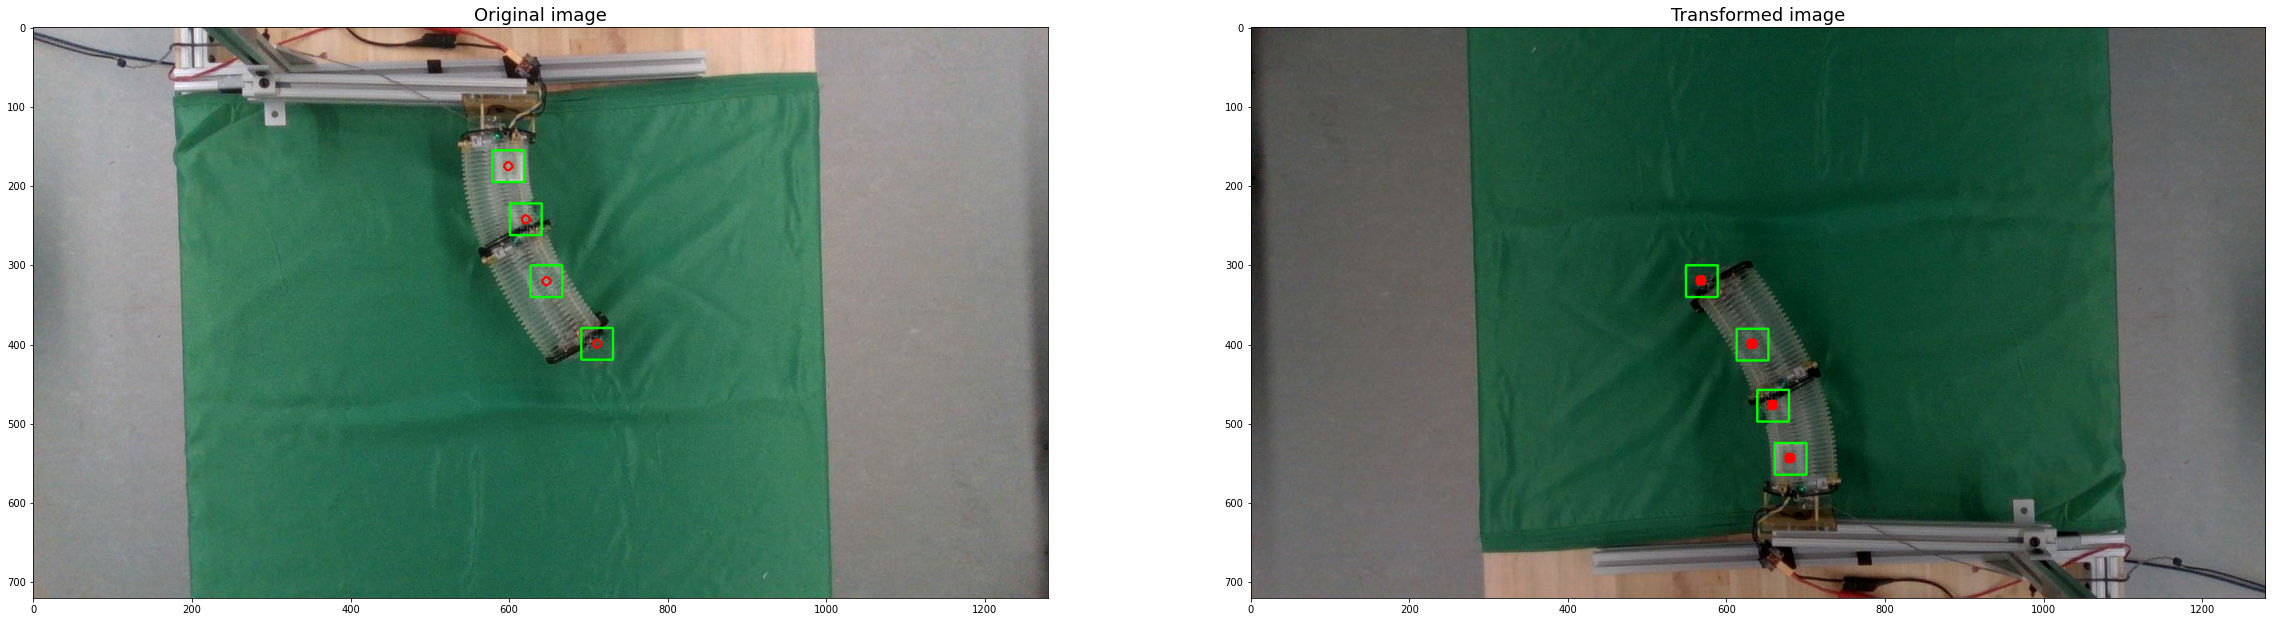

In [527]:
# function to visualize how the transformed data looks 

keypoints_classes_ids2names = {0: 'base_joint', 1: 'joint2', 2: 'joint3', 3: 'joint4', 4: 'joint5', 5: 'joint6',\
                              6:'joint7', 7:'joint8', 8:'panda_finger_1', 9:'panda_finger_2'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for idx, kps in enumerate(keypoints):
        for kp in kps:
            image = cv2.circle(image.copy(), tuple(kp), 2, (255,0,0), 10)
#         image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)
        
        return image

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        print(keypoints_original)
        for idx, kps in enumerate(keypoints_original):
            print(idx)
            print(kps)
            for kp in kps:
                print(kp)
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 2)
#             image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        
        return None
        
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
# for kps in batch1[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#     keypoints.append([kp[:2] for kp in [kps]])
    
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
# for kps in batch1[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#     keypoints_original.append([kp[:2] for kp in [kps]])
    
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

In [528]:
# def get_model(num_keypoints, weights_path=None):
    
#     anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
#     model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
#                                                                    pretrained_backbone=True,
#                                                                    num_keypoints=num_keypoints,
#                                                                    num_classes = 4, # Background is the first class, object is the second class
#                                                                    rpn_anchor_generator=anchor_generator)

#     if weights_path:
#         state_dict = torch.load(weights_path)
#         model.load_state_dict(state_dict)        
        
#     return model

In [529]:
class GraphConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphConv, self).__init__()
        self.fc = nn.Linear(in_channels, out_channels)

    def forward(self, x, adj):
        print("shape of x", x.shape)
        print("shape of adj", adj.shape)
        batch_size = adj.size(0)  # Assuming adj_matrix has a shape of [batch_size, 4, 4]
        if x.dim() == 2:
            # It means we have the shape [4, 3] for x, adjust accordingly
            x = x.unsqueeze(0).expand(batch_size, -1, -1)
        else:
            # We assume the shape is [4, 4, 128]
            x = x.permute(1, 0, 2)
        out = torch.bmm(adj, x)
        out = self.fc(out)
        return out

In [530]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.keypoint_rcnn = torchvision.models.detection.keypointrcnn_resnet50_fpn(
            pretrained=False, pretrained_backbone=True, num_keypoints=4, num_classes=5)
        self.graph_conv1 = GraphConv(3, 128)
        self.graph_conv2 = GraphConv(128, 3)
    
    def complete_missing_keypoints(self, keypoints, labels, num_expected_keypoints=4):

        detected_kps = keypoints.shape[0]
        print(labels)
        # Check if all keypoints are detected
        if detected_kps == num_expected_keypoints:
            return keypoints
        
        if detected_kps == 0:
            # Placeholder: If no keypoints are detected, set to center or other static position
            default_value = torch.tensor([640, 360, 1], device=keypoints.device)
            missing_kps_tensor = torch.full((num_expected_keypoints, keypoints.shape[1]), default_value)
            return missing_kps_tensor
        
        # Create a placeholder tensor for keypoints with the correct shape
        ordered_keypoints = torch.zeros((num_expected_keypoints, 3), device=keypoints.device)

        # If some keypoints are detected, compute their average position
        average_kp = torch.mean(keypoints, dim=0, keepdim=True)

        for i, label in enumerate(labels):
            ordered_keypoints[label - 1] = keypoints[i]

        # Fill in the missing keypoints with the average position
        missing_indices = (torch.sum(ordered_keypoints, dim=1) == 0).nonzero(as_tuple=True)[0]
        ordered_keypoints[missing_indices] = average_kp

        return ordered_keypoints

    def forward(self, images, boxes, adj_matrix=None, targets=None, train=False):
        if train:
            output = self.keypoint_rcnn(images, targets)
            return output  # This contains the losses during training
        else:
            with torch.no_grad():  # Deactivates autograd, reduces memory usage and speeds up computations
                self.keypoint_rcnn.eval()  # Set to evaluation mode
                output = self.keypoint_rcnn(images)
                self.keypoint_rcnn.train()  # Revert to training mode
#             print(output[0].keys())
            keypoints = output[0]['keypoints'].detach().cpu().numpy()
            kp_score = output[0]['keypoints_scores'].detach().cpu().numpy()
            
            boxes = output[0]['boxes'].detach().cpu().numpy()
            labels = output[0]['labels'].detach().cpu().numpy()                
            unique_labels = list(set(labels))
#             print(unique_labels)
            scores = output[0]['scores'].detach().cpu().numpy()      
            
            kps = []
            kp_scores = []
            bboxes = []
            ulabels = []
            
            for label in unique_labels:
                #find the index with highest score for this label
                indices = [i for i,x in enumerate(labels) if x == label]
                scores_for_label = [scores[i] for i in indices]
                max_score_index = indices[scores_for_label.index(max(scores_for_label))]
                kp_score_label = kp_score[max_score_index].tolist()
                # Add corresponding box, keypoint, and label to the result                
                kps.append(keypoints[max_score_index][kp_score_label.index(max(kp_score_label))])              
                
                bboxes.append(boxes[max_score_index])
                ulabels.append(label)
            
            kps = [torch.tensor(kp, dtype=torch.float32) for kp in kps]
            bboxes = [torch.tensor(bbox, dtype=torch.float32) for bbox in bboxes]
            
            keypoints = torch.stack(kps)
#             print("kp before placeholder", keypoints)
            boxes = torch.stack(bboxes)
            
            keypoints = self.complete_missing_keypoints(keypoints, unique_labels, num_expected_keypoints=4)
            
#             print("keypoints with placeholder", keypoints)
            
            keypoints = self.graph_conv1(keypoints, adj_matrix)
            keypoints = nn.functional.relu(keypoints)
            keypoints = self.graph_conv2(keypoints, adj_matrix)

            return keypoints 


In [531]:
def custom_loss(predicted_keypoints, gt_keypoints, adj_matrix, loss_keypoint):
    mse_loss = nn.MSELoss()
    batch_size = adj_matrix.size(0)
#     gt_keypoints = gt_keypoints.repeat(batch_size, 1, 1)
    print("predicted_keypoints shape:", predicted_keypoints.shape)
    print("gt_keypoints shape:", gt_keypoints.shape)
    print("adj_matrix shape:", adj_matrix.shape)
    keypoint_loss = mse_loss(predicted_keypoints, gt_keypoints)
    #     box_loss = mse_loss(predicted_boxes, gt_boxes)
    # Compute pairwise differences
    diff = predicted_keypoints.unsqueeze(2) - gt_keypoints.unsqueeze(1)  # shape [1, 4, 4, 3]
    # Square the differences
    squared_diff = diff**2  # shape [1, 4, 4, 3]
    # Sum over the coordinate dimension (i.e., sum the squared differences for x, y, z coordinates)
    squared_diff_summed = squared_diff.sum(dim=-1)  # shape [1, 4, 4]
    # Use adjacency matrix to mask out unwanted differences and compute the graph loss
    graph_loss = torch.sum((1 - adj_matrix) * squared_diff_summed)    
#     graph_loss = torch.sum((1 - adj_matrix) * (predicted_keypoints - gt_keypoints)**2)
    
#     total_loss = keypoint_loss + 0.1 * box_loss + 0.01 * graph_loss + loss_keypoint
    total_loss = keypoint_loss + graph_loss + loss_keypoint
    
    return total_loss

In [532]:
def create_adjacency_matrix(num_keypoints):
    # Initialize a zero matrix
    adj_matrix = torch.zeros((num_keypoints, num_keypoints))
    
    # Fill the diagonal above the main diagonal with ones
    for i in range(num_keypoints - 1):
        adj_matrix[i, i + 1] = 1
        
    return adj_matrix

In [533]:
# Initialize model and optimizer
model = CombinedModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create adjacency matrix
num_keypoints = 4
adj_matrix = create_adjacency_matrix(num_keypoints)


In [ ]:
num_epochs = 50
batch_size = 4

KEYPOINTS_FOLDER_TRAIN = train_test_split(root_dir) +"/train" #train_test_split(root_dir) +"/train"
KEYPOINTS_FOLDER_VAL = train_test_split(root_dir) +"/val"
KEYPOINTS_FOLDER_TEST = train_test_split(root_dir) +"/test"

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
dataset_val = ClassDataset(KEYPOINTS_FOLDER_VAL, transform=None, demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

top_5_models = []

for epoch in range(num_epochs):  # for 50 epochs
    for batch_idx, batch in enumerate(data_loader_train):
        images, targets = batch  
        ground_truth_keypoints = [target['keypoints'] for target in targets]
        ground_truth_boxes = [target['boxes'] for target in targets]
        
        # Assuming you want all images to be of size [3, 720, 1280]
        desired_size = (1280, 720)  

        # Resize all images to the desired size
        resized_images = [F.resize(img, desired_size) for img in images]

        # Now stack the resized images
        images = torch.stack(resized_images)
        ground_truth_keypoints = torch.stack(ground_truth_keypoints).squeeze()
        ground_truth_boxes = torch.stack(ground_truth_boxes)

#         Create a batched adjacency matrix with the same batch size
        batch_adj_matrix = adj_matrix.repeat(batch_size, 1, 1)
        print(batch_adj_matrix.shape)
        
        optimizer.zero_grad()
        
        # Forward pass for training
        output_train = model(images, ground_truth_boxes, adj_matrix=batch_adj_matrix, targets=targets, train=True)
        print("Output keypoints shape", output_train.keys())
        
        #Forward pass for loss
        predicted_keypoints = model(images, ground_truth_boxes, adj_matrix=batch_adj_matrix, train=False)
        
        
        print("predicted keypoints", predicted_keypoints.shape)
                
        loss_keypoint = output_train['loss_keypoint']
        
        # Compute loss and backpropagate
        loss = custom_loss(predicted_keypoints, ground_truth_keypoints, 
                           adj_matrix=batch_adj_matrix, loss_keypoint=loss_keypoint)
        
        loss.backward()
        optimizer.step()
        
        # Check if the current model should be saved as a top model
        if len(top_5_models) < 5 or loss.item() < max(top_5_models, key=lambda x: x[0])[0]:
            # Save the model state and loss
            model_state = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item(),
            }
            top_5_models.append((loss.item(), model_state))

            # Sort the list based on loss (ascending order)
            top_5_models.sort(key=lambda x: x[0])

            # If there are more than 5 models, remove the one with the highest loss
            if len(top_5_models) > 5:
                top_5_models.pop()

        print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx + 1}/{len(data_loader_train)}, Loss: {loss.item()}")
        
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
    
# After all epochs, save the top 5 models to disk
for idx, (_, model_state) in enumerate(top_5_models):
    torch.save(model_state, f'best_model_{idx+1}.pth')


/home/jc-merlab/lama/results/09_04_2023/split_folder_output-2023-09-07


Copying files: 11022 files [00:01, 6259.99 files/s]


/home/jc-merlab/lama/results/09_04_2023/split_folder_output-2023-09-07


Copying files: 11022 files [00:02, 5271.57 files/s]


/home/jc-merlab/lama/results/09_04_2023/split_folder_output-2023-09-07


Copying files: 11022 files [00:02, 4341.99 files/s]


torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1, 2, 3]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 1/965, Loss: 31904728.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1, 3]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 2/965, Loss

[3]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 17/965, Loss: 25979024.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[3]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 18/965, Loss: 22919348.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 1/50, Batch 33/965, Loss: 24612106.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 34/965, Loss: 27369622.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4

[1, 4]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 50/965, Loss: 15813572.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 51/965, Loss: 24123556.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 1/50, Batch 66/965, Loss: 19058344.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 67/965, Loss: 17651094.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4

[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 83/965, Loss: 16887966.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 84/965, Loss: 16109273.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 1/50, Batch 99/965, Loss: 17448280.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 100/965, Loss: 17538392.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 

[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 116/965, Loss: 22608598.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 117/965, Loss: 18975232.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 1/50, Batch 132/965, Loss: 16254266.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 133/965, Loss: 19685096.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4,

[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 149/965, Loss: 22845460.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 150/965, Loss: 13798142.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 1/50, Batch 165/965, Loss: 17462404.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 166/965, Loss: 22148102.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4,

[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 182/965, Loss: 16771259.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 183/965, Loss: 12699977.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 1/50, Batch 198/965, Loss: 23920792.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 199/965, Loss: 15966592.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4,

[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 215/965, Loss: 17459854.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 216/965, Loss: 15488135.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 1/50, Batch 231/965, Loss: 17420840.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 232/965, Loss: 19214420.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1, 3]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size(

[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 248/965, Loss: 21075466.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 249/965, Loss: 16399774.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 1/50, Batch 264/965, Loss: 21317206.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1, 3]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 265/965, Loss: 14752473.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size(

[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 281/965, Loss: 12496095.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 282/965, Loss: 15380563.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 1/50, Batch 297/965, Loss: 20236820.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 298/965, Loss: 13682746.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4,

[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 314/965, Loss: 12992400.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 315/965, Loss: 14861933.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 1/50, Batch 330/965, Loss: 15042391.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 331/965, Loss: 17942520.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4,

[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 347/965, Loss: 13694142.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[1]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 348/965, Loss: 19908682.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 1/50, Batch 363/965, Loss: 13527481.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[3]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 364/965, Loss: 13755898.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[3]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4,

[3]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 380/965, Loss: 16266870.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[3]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 381/965, Loss: 14034720.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 1/50, Batch 396/965, Loss: 15325886.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 397/965, Loss: 13971480.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4,

[4]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 413/965, Loss: 25773290.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4]
shape of x torch.Size([4, 3])
shape of adj torch.Size([4, 4, 4])
shape of x torch.Size([4, 4, 128])
shape of adj torch.Size([4, 4, 4])
predicted keypoints torch.Size([4, 4, 3])
predicted_keypoints shape: torch.Size([4, 4, 3])
gt_keypoints shape: torch.Size([4, 4, 3])
adj_matrix shape: torch.Size([4, 4, 4])
Epoch 1/50, Batch 414/965, Loss: 17123800.0
torch.Size([4, 4, 4])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box